In [82]:
from rsmine.coarsegrainer.cg_utils import *
from rsmine.coarsegrainer.analysis_utils import *

from examples.AB_prepare_dataset import *

examples_dir = '../examples' 
regions_data_dir = examples_dir + '/quasiperiodic_data/regions/'

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.plotting as splt

In [215]:
def rel_angle(vec, factor, vertex_type=None, ref_vec=None):
    """Returns the angle between vec and the reference vector.
    Used for rotating scaled elementary polygons.

    vertex_type is needed to determine the reference vector from the list
    """

    if ref_vec is None and vertex_type is not None:
        ref_vec = factor * nodepos[super_vertices[vertex_type][1][0]]

    dir = 'cw'
    rot = np.cross(vec, ref_vec)
    vdir = 'cw' if rot > 0 else 'ccw'

    r = (vec[0]*ref_vec[0]+vec[1]*ref_vec[1])/(np.linalg.norm(vec)*np.linalg.norm(ref_vec))

    angle = np.arccos(r)

    if vdir != dir:
        angle = 2*np.pi - angle

    return angle

    #return np.arccos(np.dot(vec, ref_vec) / (np.linalg.norm(vec)*np.linalg.norm(ref_vec)))


In [2]:
elementary_polygon_periphery_coordinates = {}


In [3]:
silver_ratio = 1 + np.sqrt(2)

super_vertices = {'8fold': {1: [389], 2:[389], 3:[389], 4:[389]}, 
                  '3fold': {1: [393], 
                            2: [404, 399, 3742, 7010, 10286, 13554, 16830, 20098], 
                            3: [429, 447], 
                            4: [274, 196]},
                    '4fold': {1: [395]},
                    '5Afold': {1: []},
                    '5Bfold': {1: [553]},
                    '6fold': {1: []},
                    '7fold': {1: []}}

In [4]:
def plot_region(edge_list:list, node_size:float=10, figsize:tuple=(4,4),):
    weights = np.ones((len(edge_list), 1))
    small_V_visualize(edge_list, weights, edges=edges, nodes=nodes,
                      nodepos=nodepos, node_size=node_size, figsize=figsize)

In [5]:
def sorted_polygon(delV: nx.classes.graph.Graph, edge_type: str, sigma_scale: int = 1, polygon_id: int = 0):

    origin_pos = nodepos[super_vertices[edge_type][sigma_scale][polygon_id]]
    delV_pos = np.array([nodepos[int(node_id)] for node_id in delV.nodes])

    shifted_delV_pos = delV_pos - origin_pos

    sorted_delV_pos = np.array(
        sorted(shifted_delV_pos, key=lambda x: np.arctan2(x[0], x[1]))) + origin_pos

    return sorted_delV_pos


In [6]:
def scale_Vgraph(sigma_scale: int, vertex_type: str, sorted_delV_pos=None, 
                delta: float=1+np.sqrt(2), eps: float=1e-5, central_pos_sigma1=None,
                plot: bool=False, figsize=None):
    """
    Scale the coarse-grained graph block according to the AB inflation rule.
    """

    factor = delta ** (sigma_scale-1) + eps

    #central_pos_sigma1 = nodepos[super_vertices[vertex_type][1][0]]
    if central_pos_sigma1 is None:
        central_pos_sigma1 = nodepos[super_vertices[vertex_type][1][0]]

    central_pos_scaled = delta ** (sigma_scale-1) * central_pos_sigma1
    #central_pos_sigma2 = nodepos[super_vertices[vertex_type][sigma_scale][0]]
    

    if sorted_delV_pos is None:
        sorted_delV_pos = elementary_polygon_periphery_coordinates[vertex_type]

    # scale the graph boundary
    polygon_sigma1 = Polygon(sorted_delV_pos)
    polygon_scaled = Polygon(
        factor * (sorted_delV_pos-central_pos_sigma1) + central_pos_scaled)
    
    # scale the graph
    node_filter = np.array([polygon_scaled.contains(Point(pos)) for pos in nodepos])
    pos_scaled = nodepos[node_filter]
    nodes_scaled = nodes[node_filter]
    pos_dict = dict(zip(nodes_scaled, pos_scaled))

    V_scaled = nx.subgraph(G, nodes_scaled)

    edgelist_scaled = construct_edgelist_from_nodes(G, nodes_scaled)

    if plot:
        if figsize is None:
            figsize = (factor, factor)

        fig, ax = plt.subplots(1, figsize=figsize)
        ax.set_aspect('equal')
        splt.plot_polygon(polygon_sigma1, ax=ax, color='b')
        splt.plot_polygon(polygon_scaled, ax=ax, color='r')
        ax.scatter(pos_scaled[:, 0], pos_scaled[:, 1], s=10, c='r')

    return edgelist_scaled, V_scaled, pos_dict, [polygon_sigma1, polygon_scaled]


def rotate_and_scale_Vgraph(angle:float, sigma_scale: int, vertex_type: str,):

    rot = np.array([[np.cos(angle), -np.sin(angle)],
               [np.sin(angle), np.cos(angle)]])

    sorted_delV_pos = elementary_polygon_periphery_coordinates[vertex_type]

    central_pos_sigma1_rot = np.dot(
        nodepos[super_vertices[vertex_type][1][0]], rot)

    sorted_delV_pos_rot = np.dot(sorted_delV_pos, rot) 

    edgelist_scaled_rot, V_scaled_rot, pos_dict_rot, polygons_rot = scale_Vgraph(sigma_scale, vertex_type, 
                                        sorted_delV_pos=sorted_delV_pos_rot,
                                        central_pos_sigma1=central_pos_sigma1_rot, plot=True)

    return edgelist_scaled_rot, V_scaled_rot, pos_dict_rot, polygons_rot
    

# Determining the elementary polygons

## $8_3$-vertex at level $\sigma^1$ ($8_4$-vertex at $\sigma^0$).

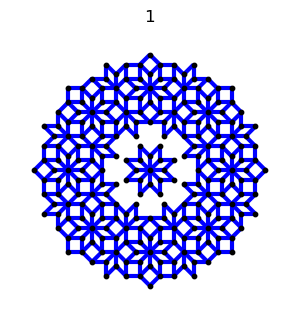

In [7]:
V_id_8sigma1 = super_vertices['8fold'][1][0]

V_edgelist_8sigma1, E_edgelist_8sigma1 = construct_VE_edgelists(
    G, V_id_8sigma1, L_B=2, ll=2, cap=10)
    
plot_region(V_edgelist_8sigma1+E_edgelist_8sigma1, figsize=(3,3))

Taking the boundary of $\mathcal{V}$-graph at the $\sigma$ scale.

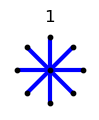

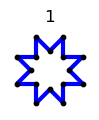

In [8]:
V_8sigma1 = G.edge_subgraph([tuple(edges[id]) for id in V_edgelist_8sigma1])

bulkV_8sigma1 = construct_VE_edgelists(G, V_id_8sigma1, L_B=1, ll=1, cap=8)
delV_edgelist_8sigma1 = list(set(V_edgelist_8sigma1) - set(bulkV_8sigma1[0]))

plot_region(bulkV_8sigma1[0], figsize=(1, 1))
plot_region(delV_edgelist_8sigma1, figsize=(1, 1))


Construct the elementary polygon for the 8-vertex, i.e. the periphery of the $\mathcal{V}$-graph on scale $\sigma^1$.

In [9]:
delV_8sigma1 = V_8sigma1.edge_subgraph([tuple(edges[id]) for id in delV_edgelist_8sigma1])


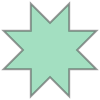

In [10]:
sorted_delV_pos_8sigma1 = sorted_polygon(delV_8sigma1, '8fold')

elementary_polygon_periphery_coordinates['8fold'] = sorted_delV_pos_8sigma1

Polygon(sorted_delV_pos_8sigma1)


#### Manual sorting process (obsolete)

[[ 1.707107 -0.707107]
 [ 1.707107  0.707107]
 [ 1.        0.      ]
 [ 0.707107  0.707107]
 [ 0.707107  1.707107]
 [ 0.        1.      ]
 [-0.707107  1.707107]
 [-0.707107  0.707107]
 [-1.707107  0.707107]
 [-1.        0.      ]
 [-1.707107 -0.707107]
 [-0.707107 -0.707107]
 [-0.707107 -1.707107]
 [-0.       -1.      ]
 [ 0.707107 -1.707107]
 [ 0.707107 -0.707107]]


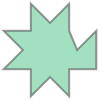

In [11]:
delV_pos_8sigma1 = np.array([nodepos[int(node_id)] for node_id in delV_8sigma1.nodes])
print(delV_pos_8sigma1)

Polygon(delV_pos_8sigma1)

# TODO: sort the V_del list to construct a polygon (i.e. along the periphery edges)

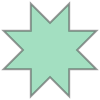

In [12]:
sorted_delV_pos_8sigma1 = delV_pos_8sigma1.copy()
sorted_delV_pos_8sigma1[[1, 2]] = sorted_delV_pos_8sigma1[[2, 1]]

Polygon(sorted_delV_pos_8sigma1)


## $5_B$-vertex at level $\sigma^1$ (7-vertex at $\sigma^0$)

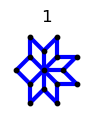

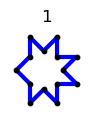

In [13]:
V_id_5Bsigma1 = super_vertices['5Bfold'][1][0]

V_edgelist_5Bsigma1 = set(construct_VE_edgelists(G, V_id_5Bsigma1,
                                                 L_B=1, ll=2, cap=20)[0]) - set([46340, 858])
bulkV_5Bsigma1 = set(construct_VE_edgelists(G, V_id_5Bsigma1, L_B=1, ll=1, cap=20)[0])

delV_edgelist_5Bsigma1 = list(V_edgelist_5Bsigma1 - bulkV_5Bsigma1)

plot_region(V_edgelist_5Bsigma1, figsize=(1, 1))
plot_region(delV_edgelist_5Bsigma1, figsize=(1, 1))

In [14]:
# Construct the networkx graphs for the bulk and delV regions

V_5Bsigma1 = G.edge_subgraph([tuple(edges[id]) for id in V_edgelist_5Bsigma1])
delV_5Bsigma1 = V_5Bsigma1.edge_subgraph(
    [tuple(edges[id]) for id in delV_edgelist_5Bsigma1])


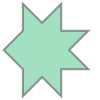

In [15]:
sorted_delV_pos_5Bsigma1 = sorted_polygon(delV_5Bsigma1, '5Bfold')

elementary_polygon_periphery_coordinates['5Bfold'] = sorted_delV_pos_5Bsigma1

Polygon(sorted_delV_pos_5Bsigma1)

### Cleaining process

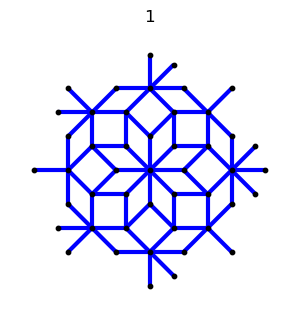

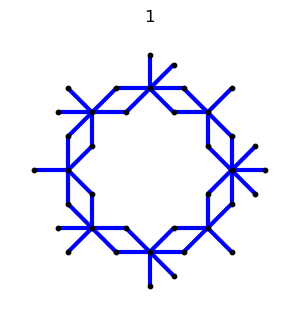

In [16]:
ballV = construct_VE_edgelists(G, 404, L_B=1, ll=4, cap=20)
bulkV = construct_VE_edgelists(G, 404, L_B=1, ll=2, cap=20)

RoF = list(set(ballV[0])-set(bulkV[0]))

plot_region(ballV[0], figsize=(3, 3))
plot_region(RoF, figsize=(3, 3))


In [17]:
G.edge_subgraph([tuple(edges[edge]) for edge in RoF]).nodes()


NodeView((393.0, 394.0, 395.0, 396.0, 397.0, 401.0, 402.0, 412.0, 413.0, 414.0, 415.0, 418.0, 420.0, 421.0, 424.0, 553.0, 426.0, 554.0, 552.0, 557.0, 559.0, 23362.0, 23363.0, 23364.0, 23365.0, 23368.0, 23369.0, 23378.0, 23379.0, 23380.0, 23381.0, 23510.0, 23511.0, 23384.0, 23514.0, 23386.0, 23388.0, 23387.0))

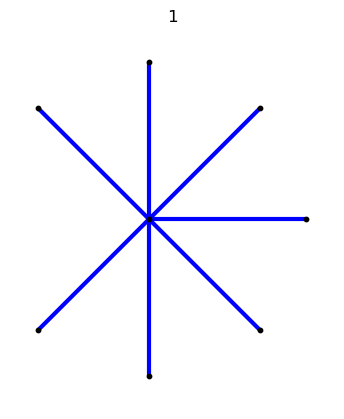

In [18]:
liste = []

for V_id in [553.0,]:

    liste += construct_VE_edgelists(G, V_id, L_B=1, ll=1, cap=20)[0]

plot_region(liste, figsize = (4, 4))



## $4$-vertex at level $\sigma^1$ ($6$-vertex at $\sigma^0$).

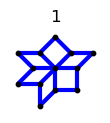

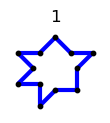

In [19]:
V_id_4sigma1 = super_vertices['4fold'][1][0]

V_edgelist_4sigma1 = set(construct_VE_edgelists(G, V_id_4sigma1,
                L_B=1, ll=2, cap=20)[0]) - set([865, 873, 817, 829])
bulkV_4sigma1 = set(construct_VE_edgelists(G, V_id_4sigma1, L_B=1, ll=1, cap=20)[0])

delV_edgelist_4sigma1 = list(V_edgelist_4sigma1 - bulkV_4sigma1)

plot_region(V_edgelist_4sigma1, figsize=(1, 1))
plot_region(delV_edgelist_4sigma1, figsize=(1, 1))


In [20]:
# Construct the networkx graphs for the bulk and delV regions

V_4sigma1 = G.edge_subgraph([tuple(edges[id]) for id in V_edgelist_4sigma1])
delV_4sigma1 = V_4sigma1.edge_subgraph([tuple(edges[id]) for id in delV_edgelist_4sigma1])


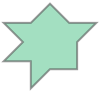

In [21]:
sorted_delV_pos_4sigma1 = sorted_polygon(delV_4sigma1, '4fold')

elementary_polygon_periphery_coordinates['4fold'] = sorted_delV_pos_4sigma1

Polygon(sorted_delV_pos_4sigma1)



### Cleaning process (used to arrive at the above final result)

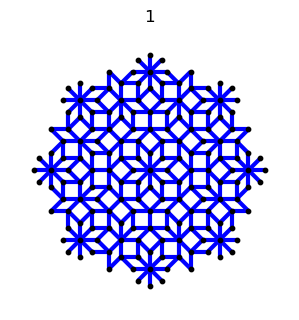

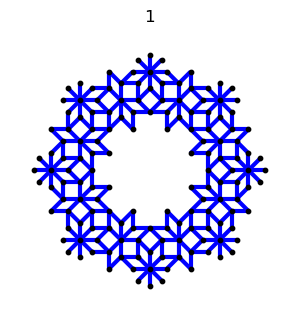

In [22]:
ballV = construct_VE_edgelists(G, 389, L_B=1, ll=8, cap=20)
bulkV = construct_VE_edgelists(G, 389, L_B=1, ll=4, cap=20)

plot_region(ballV[0], figsize=(3, 3))
plot_region(list(set(ballV[0])-set(bulkV[0])), figsize=(3, 3))


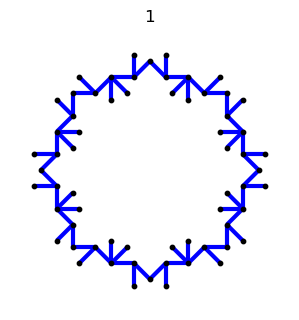

In [23]:
V_id_6sigma1 = 389

ballV = construct_VE_edgelists(G, V_id_6sigma1, L_B=1, ll=6, cap=20)
bulkV = construct_VE_edgelists(G, V_id_6sigma1, L_B=1, ll=5, cap=20)

RoF = list(set(ballV[0])-set(bulkV[0]))

#plot_region(ballV_6sigma1[0], figsize=(3, 3))
plot_region(RoF, figsize=(3, 3))


In [24]:
G.edge_subgraph([tuple(edges[edge]) for edge in RoF]).nodes()


NodeView((13575.0, 13576.0, 13578.0, 10277.0, 10278.0, 10279.0, 10281.0, 10285.0, 10303.0, 10304.0, 10305.0, 23362.0, 23363.0, 23364.0, 23366.0, 23370.0, 23387.0, 23388.0, 7005.0, 7006.0, 7007.0, 7009.0, 7014.0, 7031.0, 7032.0, 7034.0, 20093.0, 20094.0, 20095.0, 20097.0, 20102.0, 394.0, 395.0, 396.0, 398.0, 403.0, 3733.0, 3734.0, 20119.0, 20120.0, 3737.0, 20122.0, 3735.0, 3741.0, 421.0, 422.0, 424.0, 425.0, 3759.0, 3760.0, 3761.0, 16821.0, 16822.0, 16823.0, 16825.0, 16829.0, 16847.0, 16848.0, 16849.0, 13549.0, 13550.0, 13551.0, 13553.0, 13558.0))

## $3$-vertex at level $\sigma^1$ ($5_A$-vertex at $\sigma^0$).

In [25]:
V_id_3sigma1 = super_vertices['3fold'][1][0]
V_id_3sigma2 = super_vertices['3fold'][2][0]


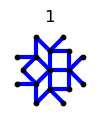

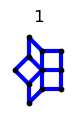

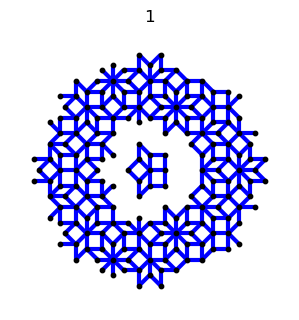

In [26]:
V_edgelist_3sigma1, E_edgelist_3sigma1 = construct_VE_edgelists(G, V_id_3sigma1, L_B=2, ll=2, cap=9)

plot_region(V_edgelist_3sigma1, figsize=(1, 1))

V_edgelist_cleaned_3sigma1 = list(set(V_edgelist_3sigma1) - set([807, 877, 879, 46284, 46289, 793]))

plot_region(V_edgelist_cleaned_3sigma1, figsize=(1, 1))

plot_region(V_edgelist_cleaned_3sigma1 + E_edgelist_3sigma1, figsize=(3, 3))


Taking the boundary of $\mathcal{V}$ graph at the $\sigma$ scale.

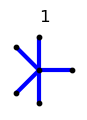

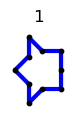

In [27]:
V_3sigma1 = G.edge_subgraph([tuple(edges[id])
                            for id in V_edgelist_cleaned_3sigma1])

bulkV_3sigma1 = construct_VE_edgelists(G, V_id_3sigma1, L_B=1, ll=1, cap=8)
delV_edgelist_3sigma1 = list(set(V_edgelist_cleaned_3sigma1) - set(bulkV_3sigma1[0]))

plot_region(bulkV_3sigma1[0], figsize=(1, 1))
plot_region(delV_edgelist_3sigma1, figsize=(1, 1))


In [28]:
# Construct the networkx graph for delV 

delV_3sigma1 = V_3sigma1.edge_subgraph([tuple(edges[id]) for id in delV_edgelist_3sigma1])


### Construct the elementary polygon for the 3-vertex, i.e. the periphery of the $\mathcal{V}$-graph on scale $\sigma^1$.

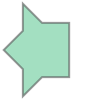

In [29]:
sorted_delV_pos_3sigma1 = sorted_polygon(delV_3sigma1, '3fold')

Polygon(sorted_delV_pos_3sigma1)


In [30]:
elementary_polygon_periphery_coordinates['3fold'] = sorted_delV_pos_3sigma1


#### Manual sorting process (obsolete)

In [31]:
delV_pos_3sigma1 = np.array([nodepos[int(node_id)] for node_id in delV_3sigma1.nodes])

# sort the nodes in the graph boundary into a loop defining the periphery of the polygon
sorted_delV_pos_3sigma1 = np.array(sorted(delV_pos_3sigma1, key=lambda x: -x[0] if x[1] > 0 else x[0]))
sorted_delV_pos_3sigma1[[2, 3]] = sorted_delV_pos_3sigma1[[3, 2]]


## Demonstration with various scales and vertex types.

In [34]:
elementary_polygon_periphery_coordinates


{'8fold': array([[ 0.      , -1.      ],
        [-0.707107, -1.707107],
        [-0.707107, -0.707107],
        [-1.707107, -0.707107],
        [-1.      ,  0.      ],
        [-1.707107,  0.707107],
        [-0.707107,  0.707107],
        [-0.707107,  1.707107],
        [ 0.      ,  1.      ],
        [ 0.707107,  1.707107],
        [ 0.707107,  0.707107],
        [ 1.707107,  0.707107],
        [ 1.      ,  0.      ],
        [ 1.707107, -0.707107],
        [ 0.707107, -0.707107],
        [ 0.707107, -1.707107]]),
 '5Bfold': array([[ 7.535534, -1.707107],
        [ 7.535534, -0.707107],
        [ 6.828427,  0.      ],
        [ 7.535534,  0.707107],
        [ 7.535534,  1.707107],
        [ 8.242641,  1.      ],
        [ 8.949747,  1.707107],
        [ 8.949747,  0.707107],
        [ 9.949747,  0.707107],
        [ 9.242641,  0.      ],
        [ 9.949747, -0.707107],
        [ 8.949747, -0.707107],
        [ 8.949747, -1.707107],
        [ 8.242641, -1.      ]]),
 '4fold': array([

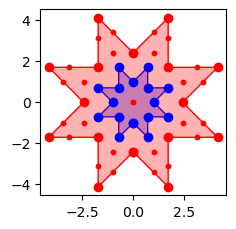

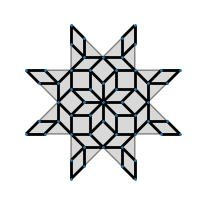

In [35]:
sigma_scale = 2
vertex_type = '8fold'

factor = silver_ratio ** (sigma_scale-1)

edgelist_scaled, V_sigma2, pos_dict, polygons = scale_Vgraph(
    sigma_scale, vertex_type, plot=True)

fig, ax = plt.subplots(1, figsize=(factor, factor))
ax.set_aspect('equal')

splt.plot_polygon(polygons[1], ax=ax, color='gray', add_points=False)
nx.draw(V_sigma2, pos=pos_dict, node_size=1, width=2, ax=ax)


### Include rotations

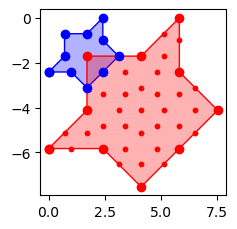

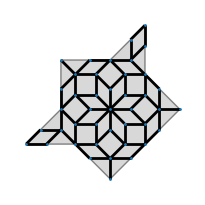

In [208]:
sigma_scale = 2
vertex_type = '3fold'

theta = np.pi/4 # generator of symmetric rotations
angle = 1*theta

factor = silver_ratio ** (sigma_scale-1)

edgelist_scaled_rot, V_sigma2_rot, pos_dict_rot, polygons_rot = rotate_and_scale_Vgraph(angle, sigma_scale, vertex_type)

fig, ax = plt.subplots(1, figsize=(factor,factor))
ax.set_aspect('equal')

splt.plot_polygon(polygons_rot[1], ax=ax, color='gray', add_points=False)
nx.draw(V_sigma2_rot, pos=pos_dict_rot, node_size=1, width=2, ax=ax)


In [248]:
angle = -4*theta
vertex_type = '3fold'
sigma_scale = 4
factor = silver_ratio ** (sigma_scale-1)

print(angle)

rot = np.array([[np.cos(angle), -np.sin(angle)],
               [np.sin(angle), np.cos(angle)]])

# 
central_pos_scaled = factor * nodepos[super_vertices[vertex_type][1][0]]# nodepos[196]
central_pos_scaled_rot = np.dot(central_pos_scaled, rot)

print(central_pos_scaled_rot)

centfilter = [np.allclose(central_pos_scaled_rot, pos) for pos in nodepos]

central_index = np.arange(len(nodepos))[centfilter][0]
print(central_index)

print(nodepos[central_index])


-3.141592653589793
[-3.39705689e+01  4.16019485e-15]
10160
[-33.970563   0.      ]


3.141592653589793


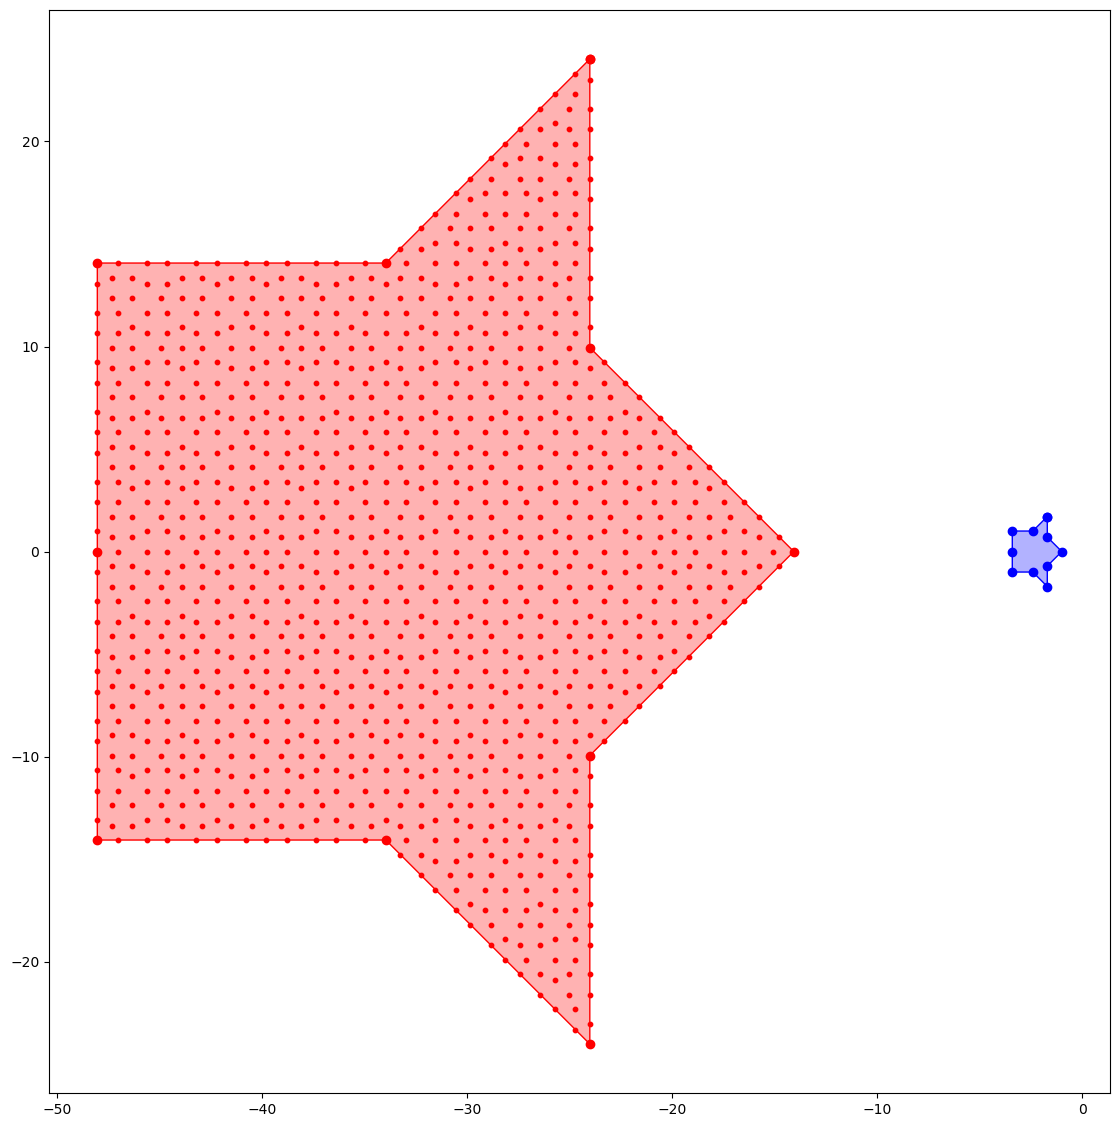

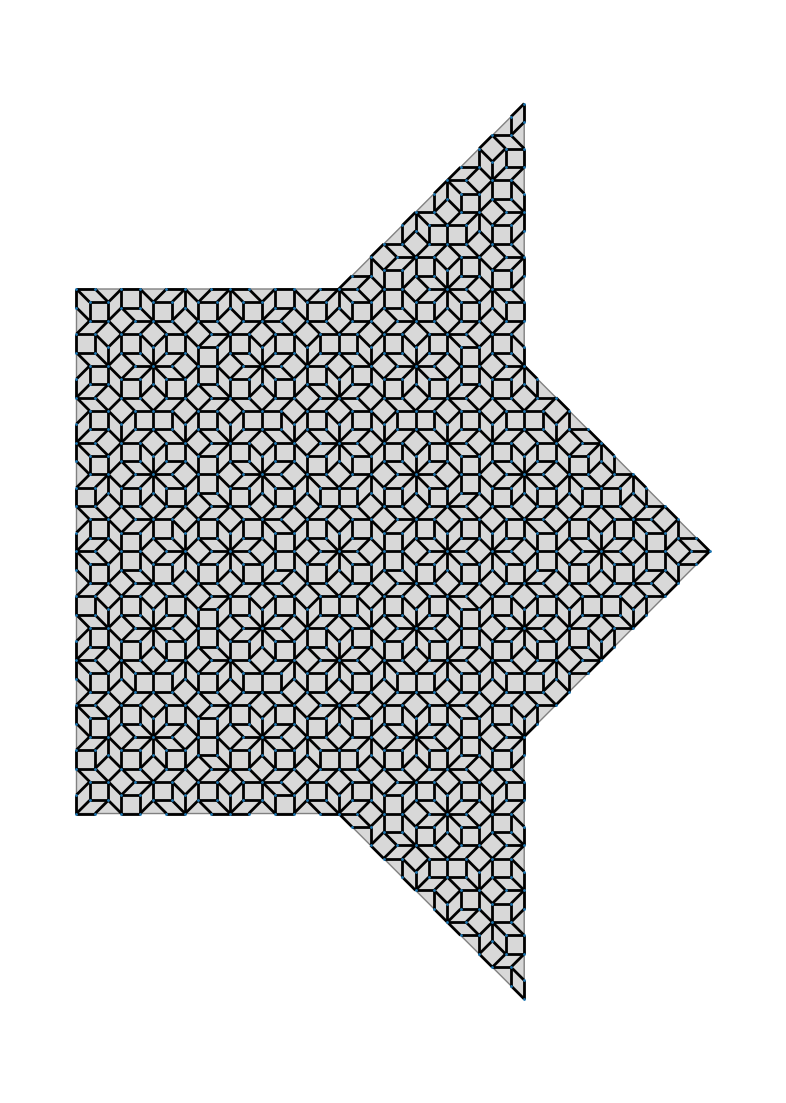

In [249]:
V_index = 10160  # 13554

#angle = np.arccos(
#    np.dot(nodepos[V_index], factor*nodepos[super_vertices[vertex_type][1][0]])/
#    (np.linalg.norm(nodepos[V_index])*np.linalg.norm(factor*nodepos[super_vertices[vertex_type][1][0]])))

angle = rel_angle(nodepos[V_index], factor, vertex_type=vertex_type)

print(angle)

edgelist_scaled_rot, V_sigma2_rot, pos_dict_rot, polygons_rot = rotate_and_scale_Vgraph(
    angle, sigma_scale, vertex_type)

fig, ax = plt.subplots(1, figsize=(factor, factor))
ax.set_aspect('equal')

splt.plot_polygon(polygons_rot[1], ax=ax, color='gray', add_points=False)
nx.draw(V_sigma2_rot, pos=pos_dict_rot, node_size=1, width=2, ax=ax)


[792, 793, 796, 797, 798, 799, 800, 801, 802, 803, 7438, 7440, 13912, 13914, 20386, 20388, 26860, 26862, 33334, 33336, 39808, 39810, 46282, 46284]
[39808, 802, 33336]


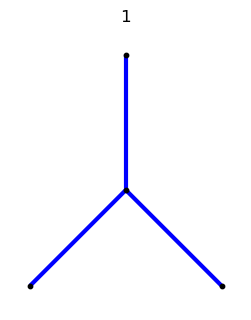

In [100]:
vedgelist = construct_VE_edgelists(G, 389, L_B=2, ll=2, cap=5)[0]
print(vedgelist)

rof = list(set(vedgelist)-set([796, 797, 798, 799, 800, 801, 803, 792, 793, 7438, 7440, 13912, 13914, 20386, 20388, 26860, 26862, 33334, 39810, 46282, 46284]))

print(rof)

plot_region(rof, figsize=(3,3))




## Manual subpartitioning for the central 8-vertex in level $\sigma^2$ (obsolete).

In [ ]:
V_id_8sigma2 = super_vertices['8fold'][2][0]
V_order = 4

reg_edges1_ids = eids_from_edges(edges, np.loadtxt(
    regions_data_dir + 'reg_edgelist_svtx%i_sord%i_mem1.dat' % (V_id_8sigma2, V_order), dtype=int))


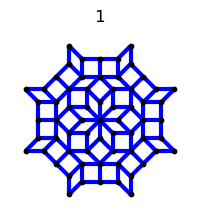

In [ ]:
V_edgelist = sorted(set(reg_edges1_ids))

plot_region(V_edgelist, figsize=(2,2))


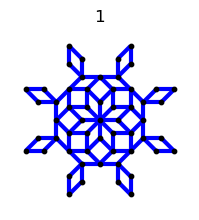

In [ ]:
V_edgelist_cleaned = list(set(V_edgelist) - 
                        set([13980, 13982,
                           26928, 26930,
                           39876, 39878,
                           7506, 7508,
                           868, 870,
                           20454, 20456,
                           876, 878,
                           33402, 33404]) -
                        set([13979, 26927, 39875, 7505, 867, 20453, 875, 33401]))

plot_region(V_edgelist_cleaned, figsize=(2,2))


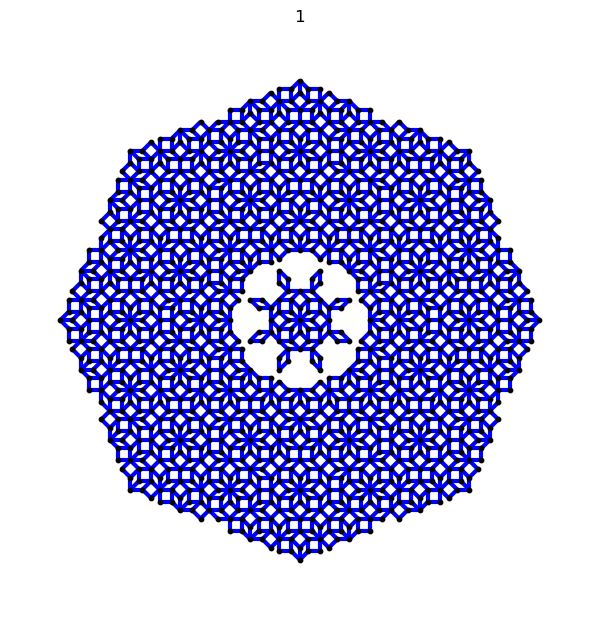

In [ ]:
_, E_edgelist = construct_VE_edgelists(G, V_id_8sigma2, L_B=3, ll=4, cap=24)

plot_region(V_edgelist_cleaned + E_edgelist, figsize=(6, 6))

### Cleaning process

[array([20092., 20093.]), array([20092., 20095.]), array([20094., 20093.]), array([20094., 20095.]), array([3731., 3733.]), array([3731., 3735.]), array([3734., 3733.]), array([3734., 3735.]), array([7033., 7007.]), array([ 7033., 10279.]), array([392., 394.]), array([392., 396.]), array([395., 394.]), array([395., 396.]), array([10275., 10277.]), array([10275., 10279.]), array([10278., 10277.]), array([10278., 10279.]), array([13577., 13551.]), array([13577., 16823.]), array([16819., 16821.]), array([16819., 16823.]), array([16822., 16821.]), array([16822., 16823.]), array([20121., 20095.]), array([20121., 23364.]), array([23361., 23362.]), array([23361., 23364.]), array([23363., 23362.]), array([23363., 23364.]), array([3762., 3733.]), array([3762., 7005.]), array([7004., 7005.]), array([7004., 7007.]), array([7006., 7005.]), array([7006., 7007.]), array([423., 396.]), array([ 423., 3735.]), array([10306., 10277.]), array([10306., 13549.]), array([426., 394.]), array([  426., 23362.]

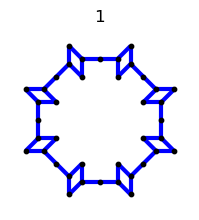

In [ ]:
outer = sorted(set(reg_edges1_ids))

inner = construct_VE_edgelists(G, V_id_8sigma2, L_B=1, ll=4, cap=8)
RoF = list(set(outer) - set(inner[0]))

plot_region(RoF, figsize=(2, 2))

print([edges[id] for id in RoF])
print()
print(RoF)

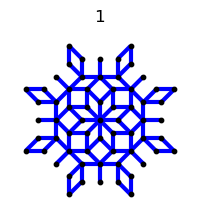

In [ ]:
V_edgelist_cleaned_aux = list(
    set(V_edgelist) - set([13980, 13982, 
                            26928, 26930, 
                            39876, 39878, 
                            7506, 7508, 
                            868, 870, 
                            20454, 20456, 
                            876, 878,
                            33402, 33404]))

plot_region(V_edgelist_cleaned_aux, figsize=(2, 2))


In [ ]:
V_edgelist_cp = V_edgelist_cleaned_aux

[array([20092., 16820.]), array([20092., 20091.]), array([20092., 20093.]), array([20092., 20095.]), array([20094., 20093.]), array([20094., 20095.]), array([3731.,  391.]), array([3731., 3732.]), array([3731., 3733.]), array([3731., 3735.]), array([3734., 3733.]), array([3734., 3735.]), array([7033., 7003.]), array([392., 391.]), array([392., 393.]), array([392., 394.]), array([392., 396.]), array([395., 394.]), array([395., 396.]), array([10275.,  7003.]), array([10275., 10276.]), array([10275., 10277.]), array([10275., 10279.]), array([10278., 10277.]), array([13577., 13547.]), array([10278., 10279.]), array([16819., 13547.]), array([16819., 16820.]), array([16819., 16821.]), array([16819., 16823.]), array([16822., 16821.]), array([16822., 16823.]), array([20121., 20091.]), array([23361.,   393.]), array([23361., 20091.]), array([23361., 23362.]), array([23361., 23364.]), array([23363., 23362.]), array([23363., 23364.]), array([3762., 3732.]), array([7004., 3732.]), array([7004., 70

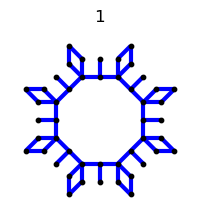

In [ ]:
outer = V_edgelist_cp

inner = construct_VE_edgelists(G, V_id_8sigma2, L_B=1, ll=3, cap=8)
RoF = list(set(outer) - set(inner[0]))

plot_region(RoF, figsize=(2, 2))

print([edges[id] for id in RoF])
print()
print(RoF)


[(20092.0, 16820.0), (20092.0, 20091.0), (3731.0, 391.0), (3731.0, 3732.0), (7033.0, 7003.0), (392.0, 391.0), (392.0, 393.0), (10275.0, 7003.0), (10275.0, 10276.0), (13577.0, 13547.0), (16819.0, 13547.0), (16819.0, 16820.0), (20121.0, 20091.0), (23361.0, 393.0), (23361.0, 20091.0), (3762.0, 3732.0), (7004.0, 3732.0), (7004.0, 7003.0), (423.0, 391.0), (10306.0, 10276.0), (426.0, 393.0), (13548.0, 10276.0), (13548.0, 13547.0), (16850.0, 16820.0)]


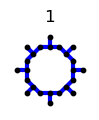

In [ ]:
outer = construct_VE_edgelists(G, V_id_8sigma2, L_B=1, ll=4, cap=8)
inner = construct_VE_edgelists(G, V_id_8sigma2, L_B=1, ll=3, cap=8)
RoF = list(set(outer[0]) - set(inner[0]))

plot_region(RoF, figsize=(1, 1))

print([tuple(edges[id]) for id in RoF])


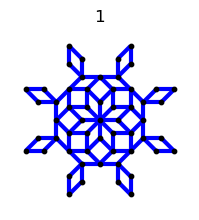

In [ ]:
V_edgelist_cleaned_further = list(
    set(V_edgelist_cleaned_aux) - set([13979, 26927, 39875, 7505, 867, 20453, 875, 33401]))

plot_region(V_edgelist_cleaned_further, figsize=(2, 2))
